# **CSE 344 - Computer Vision : Assignment 1**
**Name :** Arka Sarkar  <br>
**Roll Number :** 2018222 <br>

Importing the dependencies

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters
from collections import deque
import copy
from itertools import product
import cv2
import random as rng
import math
from scipy.spatial import distance

### Question 1 
Find tightest bounding circles for the objects present in the given image.[3 Marks] <br>
**Expected O/Ps**: centers & radiuses of those circles, and a visualization showing both the objects and the circles in a single image. <br>
[0.25] marks for the center. <br> 
[0.15] andthe radius. <br> 
[0.1] for any object. <br>
[0.75] marks for the is ualization. <br>

Loading the RBG **Project1.png** image to work upon of shape (639,960,3)

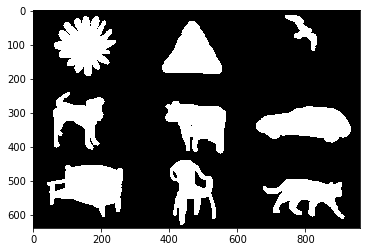

(639, 960, 3)


In [2]:
image = cv2.imread("Project1.png")
plt.imshow(image)
plt.show()
print(image.shape)

### **Connected Components**

The first part of drawing the bounding circles, is to detect the total number of connected components(objects). <br>

**Algorithm :**
* Convert the RBG image into a grayscale image.
* Apply otsu on the grayscale image and segment it into a binary image, where 1 is foreground and 0 is background.
* A counter that maintains the number of connected components found.
* Iterate through the rows and columns of the binary image and for every not visited pixel in the image mark it visited and interate through all the connected neighbours that are marked as 1 and not visited, and increment the counter. 
* Save the pixels for each connected component separately and return it along with the max number that the counter achieved. 

In [3]:
def get_components(image):
    gray_img = np.mean(image,2)
    val = filters.threshold_otsu(gray_img)
    gray_img[gray_img >= val] = 1
    gray_img[gray_img < val] = 0
    
    rows, cols = gray_img.shape[0], gray_img.shape[1]
    visited = np.zeros((rows,cols))

    answer = np.zeros((rows,cols))
    centers = {}
    boundary_pixels = {}
    c = 1
    for i in range(rows):
        for j in range(cols):

            if(gray_img[i][j] == 0.0):
                visited[i,j] = 1
            elif(visited[i,j]):
                continue
            else:
                stack = deque()
                stack.append((i,j))
                
                centers[c] = []
                boundary_pixels[c] = []
                while(len(stack)!=0):
                    curr = stack.pop()
                    if(visited[curr[0],curr[1]] == 0):
                        visited[curr[0],curr[1]] = 1
                        m,n = curr[0],curr[1]
                        answer[m,n] = c
                        list_ = []
                        for x in range(m-1, m+2):
                            for y in range(n-1, n+2):
                                if(x == m and y == n):
                                    continue
                                else:
                                    if(x <0 or x > rows -1):
                                        continue
                                    if(y <0 or y > cols -1):
                                        continue

                                    if(gray_img[x,y] == 1.0):
                                        centers[c].append((x,y))
                                        stack.append((x,y))
                                    elif(gray_img[x,y] == 0.0):
                                        boundary_pixels[c].append((x,y))
                                        
                c = c + 1


    return np.amax(answer), centers, boundary_pixels


### **Draw Bounding Circles**
The next part of is to compute the radius and the center of all the connected components, from the pixels of each component recieved from the above function. <br>

For each connected component we calculate the following metrics to get the centre and the radius of the bounding circles. We use a optimised brute force method to calculate the optimal radius by iterating through every boundary point one and finding the furthest point from the centre to select it as the radius. <br>

  $$ x_0,y_0 = min(x_i), min(y_i) $$ <br>
  $$ x_1,y_1 = max(x_i), max(y_i)$$ <br>
  $$ bb_x,bb_y = Sequence (x_0 \to x_1), Sequence (y_0 \to y_1)$$ <br>
  $$ Radius = min(min_{x \in bb_x, y \in bb_y}(max(\sqrt{(x_i - x)^2 + (y_i - y)^2})), min_{x \in obj_x, y \in obj_y}(max(\sqrt{(x_i - x)^2 + (y_i - y)^2})) ) $$ <br>
  where $(x_i,y_i)$ is the $i^{th}$ boundary pixel coordinates of the current connected component. <br>

Once we get the radius we need to now calculate the center of the circle. The center would be argmin of the radius given by : <br>

**Case 1 :** $Radius \in max(\sqrt{(x_i - x)^2 + (y_i - y)^2}),x \in bb_x, y \in bb_y  $ <br>
$$ Center(x,y) =  argmin (max(\sqrt{(x_i - x)^2 + (y_i - y)^2}),x \in bb_x, y \in bb_y) $$<br>

**Case 2 :** $Radius \in max(\sqrt{(x_i - x)^2 + (y_i - y)^2}),x \in obj_x, y \in obj_y $ <br>
$$ Center(x,y) =  argmin (max(\sqrt{(x_i - x)^2 + (y_i - y)^2}),x \in obj_x, y \in obj_y) $$ <br>

<br>

### Why does this work ? 

Since we are calculating the the optimal radius and center by manually interating through every possible center coordinate, 
the cannot be any case where we do not get the tighest bounding circle. <br>

**CASE 1 : When optimal center in inside the object** <br>

<img src="img.jpg" width="400">
$obj_x$ : X-coordinate of the object. <br>
$obj_y$ : Y-coordinate of the object. <br>
$(x_i,y_i)$ : Boundary pixels of the object. <br>

$$ Radius = min_{x \in obj_x, y \in obj_y}(max(\sqrt{(x_i - x)^2 + (y_i - y)^2}))  $$ <br>
$$ Center(x,y) =  argmin (max(\sqrt{(x_i - x)^2 + (y_i - y)^2}),x \in obj_x, y \in obj_y) $$ <br>


**CASE 2 : When optimal center in outside the object** <br>

<img src="img2.jpg" width="400">

$bb_x$ : X-coordinate of the points inside the **Enclosing Box**. <br>
$bb_y$ : Y-coordinate of the points inside the **Enclosing Box**. <br>
$(x_i,y_i)$ : Boundary pixels of the object. <br>

Since the optimal center lies outside the object but it will always lie **inside the Enclosing box**, thus if we check for the optimal center inside the Enclosing Box then we would for surely get the optimal center and the radius for the tighest bounding Circle. <br> 


$$ Radius = min_{x \in bb_x, y \in bb_y}(max(\sqrt{(x_i - x)^2 + (y_i - y)^2}))  $$ <br>
$$ Center(x,y) =  argmin (max(\sqrt{(x_i - x)^2 + (y_i - y)^2}),x \in bb_x, y \in bb_y) $$ <br>

In [30]:
def get_bounding_circles(image):
    
    n, centers, boundary_pixels = get_components(image)
    centers_radius = {}
    for key in list(centers.keys()):
        arr = np.array(centers[key])
        bound_arr = np.array(boundary_pixels[key])
        height = np.max(arr[:,1]) - np.min(arr[:,1])
        width = np.max(arr[:,0]) - np.min(arr[:,0])
        x0,y0 = np.min(arr[:,1]), np.min(arr[:,0])
        x1,y1 = np.max(arr[:,1]), np.max(arr[:,0])
        center_x,center_y = int((x0+x1)/2), int((y0+y1)/2)
        arr1 = np.array([i for i in  range(x0,x1)])
        arr2 = np.array([i for i in  range(y0,y1)])
        center_patch = np.array(np.meshgrid(arr2,arr1)).T.reshape(-1, 2)
        
        distances_bb = distance.cdist(center_patch, bound_arr)
        pixel_radius_bb = distances_bb.max(axis = 1)
        radius_bb = min(pixel_radius_bb)
        circle_center_y_bb,circle_center_x_bb = center_patch[np.argmin(pixel_radius_bb, axis = 0)]
        
        distances_obj = distance.cdist(arr, bound_arr)
        pixel_radius_obj = distances_obj.max(axis = 1)
        radius_obj = min(pixel_radius_obj)
        circle_center_y_obj,circle_center_x_obj = arr[np.argmin(pixel_radius_obj, axis = 0)]
        
        if(radius_bb < radius_obj):
            circle_center_y ,circle_center_x = circle_center_y_bb,circle_center_x_bb
            radius = radius_bb
        else:
            circle_center_y ,circle_center_x = circle_center_y_obj,circle_center_x_obj
            radius = radius_obj
        
        centers_radius[key] = {"center_coordinates" : (int(circle_center_x), int(circle_center_y)), "radius": int(radius)}
        print("centre coordinates for object ",str(key),": ", "(", int(circle_center_x), int(circle_center_y), ")", "radius : ",int(radius) )
    
    curr_image = copy.deepcopy(image)
    for key in list(centers_radius.keys()):
         
        color = (255, 0, 0)
        thickness = 2
        curr_image = cv2.circle(curr_image, centers_radius[key]["center_coordinates"], centers_radius[key]["radius"], color, thickness)
        font = cv2.FONT_HERSHEY_SIMPLEX 
        fontScale = 1
        curr_image = cv2.putText(curr_image, str(key), centers_radius[key]["center_coordinates"], font, fontScale, color, thickness, cv2.LINE_AA) 
    
    cv2.imwrite("bounding_image.jpg", curr_image)
    fig = plt.figure(figsize = (10,10))
    plt.imshow(curr_image)
    plt.show()
    
    return centers_radius

centre coordinates for object  1 :  ( 783 68 ) radius :  68
centre coordinates for object  2 :  ( 153 101 ) radius :  92
centre coordinates for object  3 :  ( 468 130 ) radius :  101
centre coordinates for object  4 :  ( 135 331 ) radius :  101
centre coordinates for object  5 :  ( 473 348 ) radius :  110
centre coordinates for object  6 :  ( 793 346 ) radius :  141
centre coordinates for object  7 :  ( 469 535 ) radius :  102
centre coordinates for object  8 :  ( 158 521 ) radius :  119
centre coordinates for object  9 :  ( 795 561 ) radius :  129


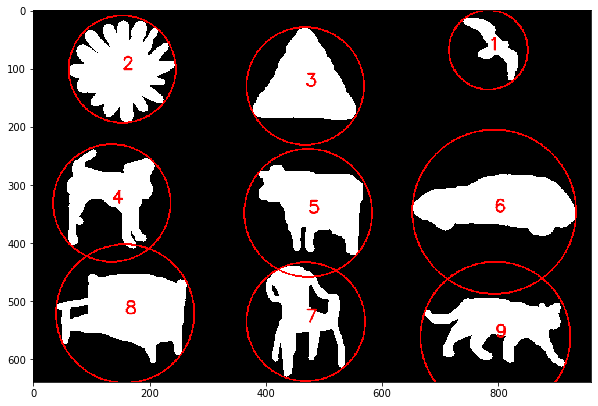

In [31]:
center_radius = get_bounding_circles(image)

### Question 2
Find Jaccard Similarity scores for each of the objects in the image given with respect to their corresponding circular regions obtained in Q1.[2 Marks] <br>
[0.65] marks for implementing the Jaccard Similarity module that takes two binary masks as inputs and outputs the required score. <br>
[0.15] marks for Jaccard Similarity score for any object. 

### Jaccard Similarity
Jaccard Similarity computes the intersection of two binary marks BM1 and BM2 divided by the union of BW1 and BW2. <br>
<br>
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
where $A,B$ are the two binary masks.

In [6]:
def jaccard_similarity(binary_mask1, binary_mask2):
    intersection = len(list(set(binary_mask1).intersection(set(binary_mask2))))
    union = len(set(binary_mask1).union(set(binary_mask2)))
    return float(intersection) / union
    

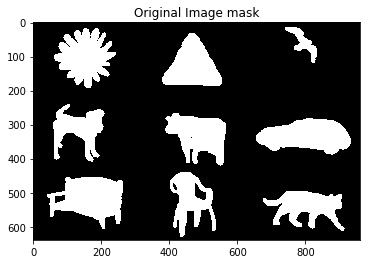

In [7]:
gray_img = np.mean(image,2)
val = filters.threshold_otsu(gray_img)
gray_img[gray_img >= val] = 1
gray_img[gray_img < val] = 0
plt.imshow(gray_img, cmap = 'gray')
plt.title("Original Image mask")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


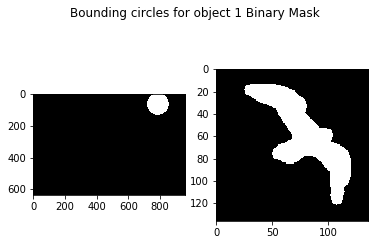

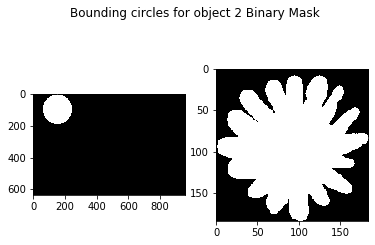

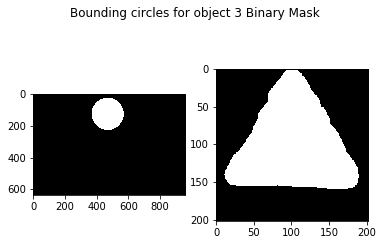

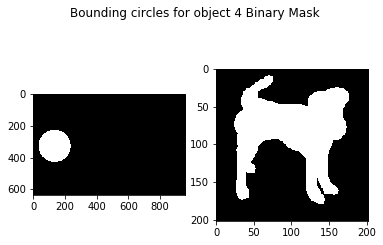

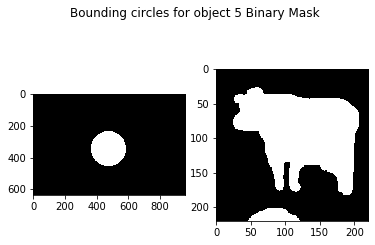

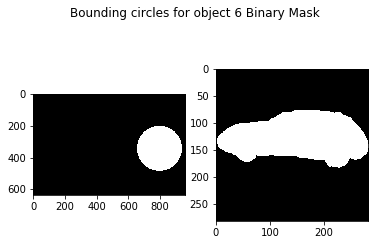

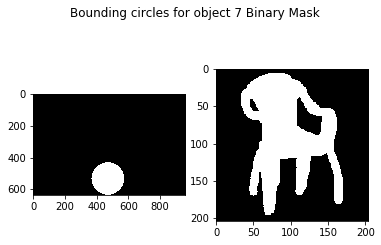

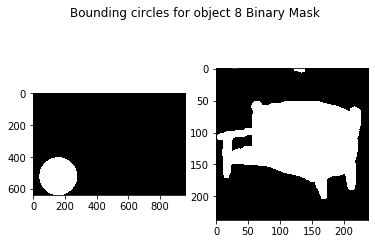

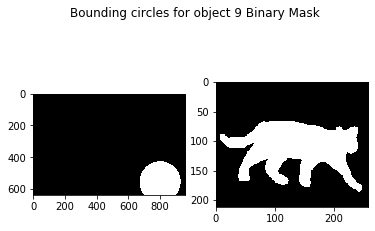

In [8]:
circles = {}
for key in list(center_radius.keys()):
    curr_image = copy.deepcopy(image)
    curr_image = np.zeros(curr_image.shape)
    color = (255, 255, 255)
    thickness = -1
    y,x = center_radius[key]["center_coordinates"]
    radius = center_radius[key]["radius"]
    curr_image = cv2.circle(curr_image, center_radius[key]["center_coordinates"], center_radius[key]["radius"], color, thickness)
#     curr_image = np.mean(curr_image,2)
#     curr_image = curr_image[x - radius : x + radius , y - radius : y + radius]
    circles[key] = curr_image
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle("Bounding circles for object " + str(key) + " Binary Mask")
    ax1.imshow(curr_image)
    ax2.imshow(image[x - radius : x + radius , y - radius : y + radius])

In [9]:
def points_in_circle_np(radius, x0=0, y0=0, ):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    list_ = []
    for x, y in zip(x_[x], y_[y]):
        list_.append((x,y))
    return list_

In [10]:
def get_jaccard_similarity(image):
    n, centers, _ = get_components(image)
    centers_radius = {}
    for key in list(centers.keys()):
        arr = np.array(centers[key])
        center_x, center_y = np.mean(arr,0)
        radius = max((np.max(arr[:,0]) - np.min(arr[:,0]))/2, (np.max(arr[:,1]) - np.min(arr[:,1]))/2)
        centers_radius[key] = {"center_coordinates" : (int(center_y), int(center_x)), "radius": int(radius)}
        
    circle_coordinates = {}
    for key in list(center_radius.keys()):
        radius = center_radius[key]["radius"]
        y,x = center_radius[key]["center_coordinates"]
        circle_coordinates[key] = points_in_circle_np(radius,x,y)
        IOU = jaccard_similarity(centers[key], circle_coordinates[key])
        print("The IOU (jaccard similarity) score for object ", str(key) ,"  is : ", IOU)
    return circle_coordinates, centers
                

The IOU (jaccard similarity) score for object  1   is :  0.23660806618407446
The IOU (jaccard similarity) score for object  2   is :  0.7265198569546396
The IOU (jaccard similarity) score for object  3   is :  0.5242527407314864
The IOU (jaccard similarity) score for object  4   is :  0.4049411250273292
The IOU (jaccard similarity) score for object  5   is :  0.45633342987283115
The IOU (jaccard similarity) score for object  6   is :  0.3270866368747297
The IOU (jaccard similarity) score for object  7   is :  0.39741745968605613
The IOU (jaccard similarity) score for object  8   is :  0.47783849423193686
The IOU (jaccard similarity) score for object  9   is :  0.29085098647071206


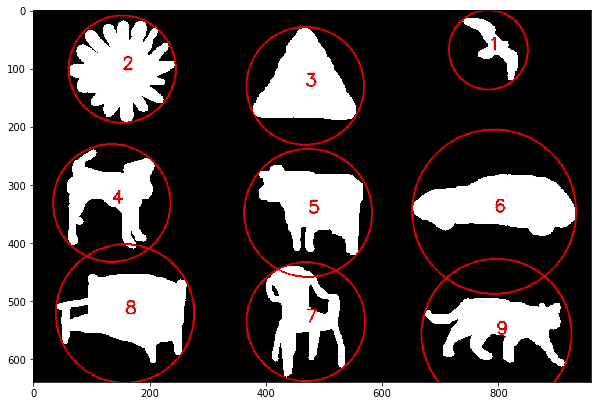

In [11]:
circle_coordinates,centers = get_jaccard_similarity(image)
bounding_image = cv2.imread("bounding_image.jpg")
plt.figure(figsize = (10,10))
plt.imshow(bounding_image)
plt.show()